# Boston Airbnb Open Data 

## Business Understadning

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.   

Using this dataset I will try to answer three questions:   
1. What are the major factors that influence the price of an Airbnb rental in Boston?
2. Which neighborhoods in Boston have the highest rental prices?
3. What time of year has the highest rental prices?

## Data Understanding

The following Airbnb activity is included in this Boston dataset:   
* Listings, including full descriptions and average review score.   
* Calendar, including listing id and the price and availability for that day.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [5]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


## Data Preparation

### Start with  listings dataset


In [7]:
def clean_listings(df):
    
    # Convert price type from string to float and remove $ sign and commas
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '').astype(float)
    df['extra_people'] = df['extra_people'].str.replace('$', '').astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').astype(float)
    
    # Covert boolean data from string type to true and false
    bool_col = ['requires_license', 'instant_bookable', 'require_guest_profile_picture', 
                'require_guest_phone_verification', 'is_location_exact', 'host_is_superhost', 'host_has_profile_pic', 
                'host_identity_verified']
    df[bool_col] = df[bool_col].replace({'t': True, 'f': False})
    
    # Since 'experiences_offered', 'state', 'country' and 'country_code' has only one value across all rows which is 'none',
    #'MA', and 'US', and 'United States' respectively, these columns will not affect the result so it will be dropped.
    # Also, cities and market are mostly Boston
    df.drop(['experiences_offered', 'state', 'country', 'country_code', 'city', 'market'], axis=1, inplace=True)
    
    # Since host_listings_count and host_total_listings_count, and 'city' and 'smart_location' have the same values, 
    #I will drop host_total_listings_count and 'smart_location'
    df.drop(['host_total_listings_count', 'smart_location'], axis=1, inplace=True)
    
    ### Drop price outliers (above 500), since most prices is less than 500
    df.drop(df[df.price > 500].index, inplace=True)

    # Investigate null values
    ## Drop columns with 50% or more missing values
    more_than_50 = list(df.columns[df.isnull().mean() > 0.5])
    df.drop(more_than_50, axis=1, inplace=True)
    
    ## Fill numerical missing data with mean value
    num_feat = df.select_dtypes(np.number)
    num_col = num_feat.columns

    imp_mean = SimpleImputer(missing_values= np.nan, strategy= 'mean')
    imp_mean = imp_mean.fit(num_feat)
    df[num_col] = imp_mean.transform(df[num_col])
    
    
    ## Fill categorical missing data with most frequent value
    cat_feat = df.select_dtypes(include='object')
    cat_col = cat_feat.columns
    
    most_freq = SimpleImputer(missing_values= np.nan, strategy= 'most_frequent')
    most_freq = most_freq.fit(cat_feat)
    df[cat_col] = most_freq.transform(df[cat_col])
    
    # Convert rates type from string to float and remove % sign
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)
    df['host_response_rate'] = df['host_response_rate']*0.01
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float)
    df['host_acceptance_rate'] = df['host_acceptance_rate']*0.01
    
     # Convert zipcode from string to int
    df['zipcode'] = df['zipcode'].str.replace(' ', '')
    df['zipcode'] = df['zipcode'].str.replace('-', '')
    df['zipcode'] = df['zipcode'].astype(int)
    
    
    # Drop URLs
    urls = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url','xl_picture_url', 'host_url', 'host_thumbnail_url',
           'host_picture_url']
    df.drop(urls, axis=1, inplace=True)
    
     
    # Drop textual features
    text_feat = ['name', 'summary', 'space', 'neighborhood_overview', 'transit', 'access', 'interaction', 'description',
                 'house_rules', 'host_name', 'host_about', 'host_location', 'host_neighbourhood', 'street', ]
    df.drop(text_feat, axis=1, inplace=True)

    
    # Drop dates 
    dates = ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review', 'host_since', 'calendar_updated']
    df.drop(dates, axis=1, inplace=True)
    
   
    return df

In [8]:
def Encode_listings(df):
    
    # Encode amenities feature
    df.amenities = df.amenities.str.replace('[{""}]', "")
    amenity_df = df.amenities.str.get_dummies(sep = ",")
    
       
    # Drop the original amenities column and concat the new dataframe
    df.drop('amenities', axis=1, inplace=True)
    df = pd.concat([df, amenity_df], axis=1)
    
    # Drop amenities with translation missing
    trans_miss = ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']
    df.drop(trans_miss, axis=1, inplace=True)
    
    
    # Encode host verification
    df.host_verifications = df.host_verifications.str.replace("['']", "")
    verification_df = df.host_verifications.str.get_dummies(sep = ",")
    verification_df = pd.concat([df, verification_df], axis=1)

    
    # Encode host_response_time
    response_dict = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
    df['host_response_time']= df['host_response_time'].map(response_dict)
    
  
    # Encode rest of categorical variables
    for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'neighbourhood', 
                                'cancellation_policy']:
        df = pd.concat([df, pd.get_dummies(df[categorical_feature])], axis=1)
        
    # Drop original categorical columns
    df.drop(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'host_verifications', 'neighbourhood',
             'cancellation_policy'], axis=1, inplace=True)
     
    return df

In [9]:
listings_clean = clean_listings(listings.copy())
listings_encoded = Encode_listings(listings_clean.copy())

In [10]:
listings_encoded.head()

,id,scrape_id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,...,Somerville,South Boston,South End,Theater District,West End,West Roxbury,flexible,moderate,strict,super_strict_30
0,12147973.0,2.016091e+13,31303940.0,1,1.0,1.00,False,1.0,True,False,...,0,0,0,0,0,0,0,1,0,0
1,3075044.0,2.016091e+13,2572247.0,1,1.0,1.00,False,1.0,True,True,...,0,0,0,0,0,0,0,1,0,0
2,6976.0,2.016091e+13,16701.0,2,1.0,0.88,True,1.0,True,True,...,0,0,0,0,0,0,0,1,0,0
3,1436513.0,2.016091e+13,6031442.0,2,1.0,0.50,False,1.0,True,False,...,0,0,0,0,0,0,0,1,0,0
4,7651065.0,2.016091e+13,15396970.0,1,1.0,1.00,True,1.0,True,True,...,0,0,0,0,0,0,1,0,0,0


### Calendar dataset

In [11]:
def clean_calendar(df):
    # Convert string boolean data into bool data type
    df['available'] = df['available'].replace({'t': True, 'f': False})
    
    # Convert price from string data type to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '').astype(float)
    
    # Convert date from object to datetime
    df['date'] =  pd.to_datetime(df['date'], infer_datetime_format=True)

    
    # Drop price outliers
    df.drop(df[df.price > 1000].index, inplace=True)
    
    # Fill missing prices with median value
    #df.fillna(df.median(),inplace=True)
    
    return df

In [12]:
calendar_clean = clean_calendar(calendar.copy())

In [13]:
calendar_clean.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

## Data Modeling

In [14]:
X = listings_encoded.drop(['price', 'id', 'host_id', 'scrape_id', 'zipcode','latitude', 'longitude'], axis=1)
y = listings_encoded['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
# Initalize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on training data
model.fit(X_train, y_train)
        
# Predict results
y_test_preds = model.predict(X_test) 

# Evaluate the result
rsquared_score = r2_score(y_test, y_test_preds)
print('R sequared = ', rsquared_score)

R sequared =  0.6829881553556947


I used a random forest regressor model because it fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The r sequared score equals to 68% which is good enough to find out the relation between features and the price.

## Question 1: 
### What are the major factors that influence the price of an Airbnb rental in Boston?

In [23]:
def feature_plot(importances, X_train, y_train):
    
    headers = ["feature", "score"]
    values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    feature_importances = pd.DataFrame(values, columns = headers)
    feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

    features = feature_importances['feature'][:10]
    y_pos = np.arange(len(features))
    scores = feature_importances['score'][:10]

    #plot feature importances
    plt.figure(figsize=(15,8))
    plt.bar(y_pos, scores, align='center')
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances (Boston Price of Airbnb)');

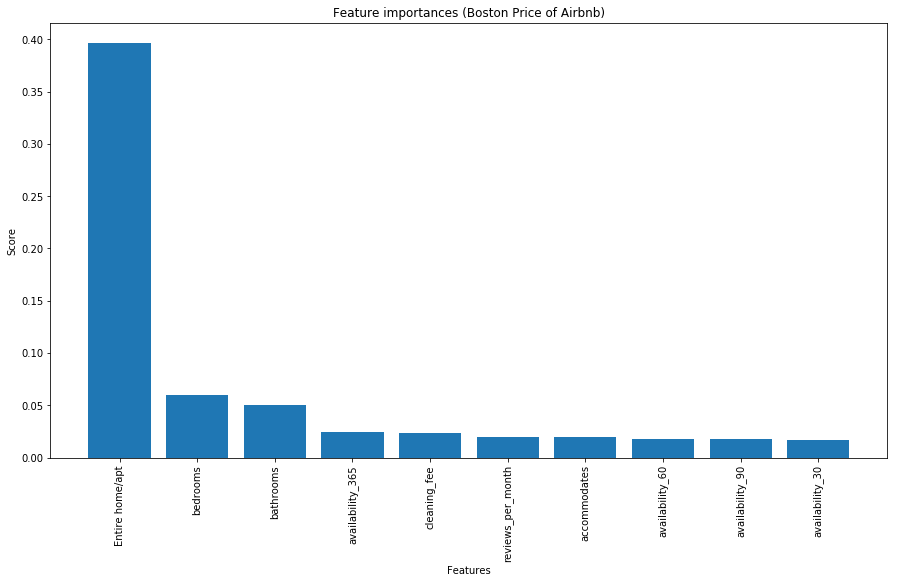

In [24]:
importances = model.feature_importances_
feature_plot(importances, X_train, y_train)

As shown in the above plot major factors that influences the price are:
1. Property type.
2. Number of bedrooms.
3. Number of bathrooms.
4. Availability of property throughout the year.
5. Cleaning fee.
6. Property accommodation.


## Question 2:   
### Which neighborhoods in Boston have the highest rental prices?


In [18]:
neighbourhood_price = listings_clean.groupby('neighbourhood_cleansed')[['price']].mean()
neighbourhood_price = neighbourhood_price.reset_index()
neighbourhood_price = neighbourhood_price.sort_values(by='price',ascending=False)

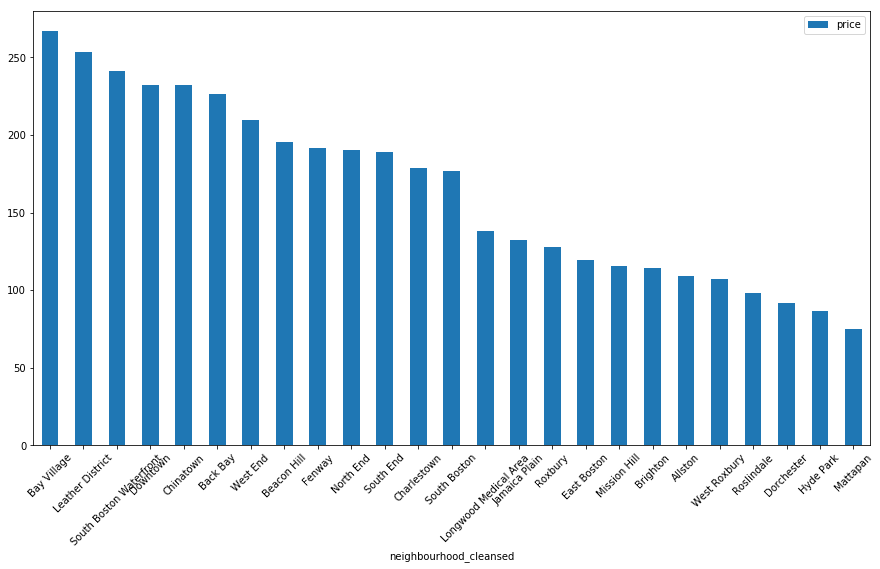

In [19]:
ax = neighbourhood_price.plot.bar(x='neighbourhood_cleansed', y='price', rot=45, figsize = (15,8))

As shown in the above plot Bay Village has the highest rental price, then Leather District, then South Boston Waterfront Downtown. 

## Question 3:
### What time of year has the highest rental prices?

In [20]:
timeline = calendar_clean.groupby(['date'])['price'].mean()
timeline = timeline.to_frame().reset_index()
timeline = timeline.sort_values(by='date',ascending=True)

In [21]:
timeline

,date,price
0,2016-09-06,241.043860
1,2016-09-07,251.833691
2,2016-09-08,247.992986
3,2016-09-09,260.800000
4,2016-09-10,262.938220
5,2016-09-11,245.749746
6,2016-09-12,245.732597
7,2016-09-13,245.841676
8,2016-09-14,256.647799
9,2016-09-15,262.932730


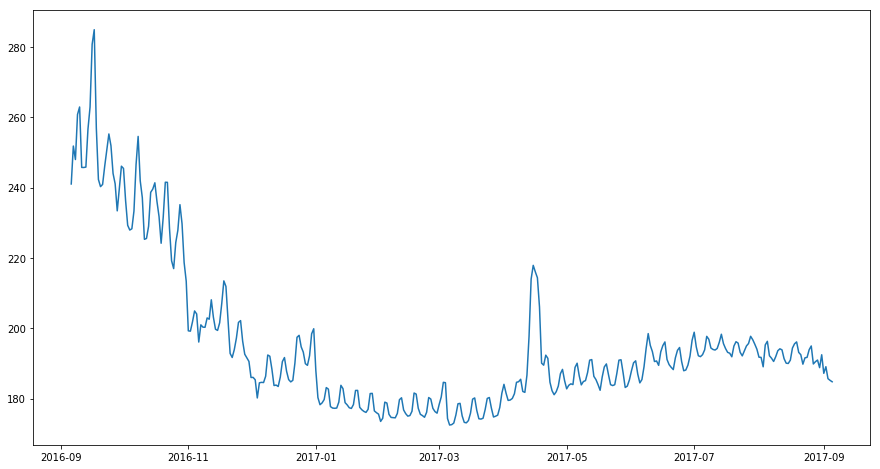

In [22]:
plt.figure(figsize=(15,8))
plt.plot(timeline['date'],timeline['price'])

The time of the year with the highest price is september and October. 